This Jupyter notebook, which is based on Python 3, is designed to calculate the abundances of N elements in the neutron star merger mixture. The notebook will contain several functions to easily calculate values such as temperature, abundances, and ionization potentials.

In this notebook, I have a function for the potentials, initialization of values, calculation of abundances, and plotting

In [1]:
#Importing Libraries
import saha_mult #Class used to calculate abundances 
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as sc
from time import process_time #Useful for finding calculation times
import pickle #for saving data in lists to txt files.


import importlib 
importlib.reload(saha_mult) #This command ensures that any changes made to saha_mult class are reflected in this notebook

<module 'saha_mult' from 'C:\\Users\\prana\\Documents\\Research\\R-process_Mergers\\Abundance_Calculations\\Fixing_Cutoff\\saha_mult.py'>

In [2]:
#Read in data for ionization potentials and skynet stuff
#Note that the NIST data table includes many elements that just skip ionization potentials, so I set a cutoff at Lr.
nist = pd.read_excel("NIST Data Table.xlsx")
hf = h5py.File("SkyNet_r-process.h5")

In [3]:
#This function here will return all the ionization potentials of the desired elements. Enter the starting element and
#ending element Z number. This will return an array of arrays. Note the starting position of the array!

#The way I did this was similar to the Multiple Elements Scenario code, but I added an extra array called 
#returned_potentials, which is designed to return an array of all the desired potentials we wanted
ion_energies1d =  nist[' Ionization  Energy (eV)']

def ionization_generator(elements):
    max_el = 103 #This is defined to be the Z of the last element that I want in the list 
    ion_energies = list()
    returned_potentials = list()
    counter = 0

    for i in range(0,max_el+1):
        specific_list = list()

        for j in range(i):

            if isinstance(ion_energies1d[counter],str):

                if len(ion_energies1d[counter]) ==3:
                    specific_list.append(0)
                    counter+=1
                else:
                    str_num = '' 

                    for k in ion_energies1d[counter]:

                        if (k != ' ') and (k !='[') and (k !=']') and (k !='(') and (k !=')'):
                            str_num+=k

                    specific_list.append(np.abs(float(str_num)))
                    counter+=1


            else:
                specific_list.append(np.array((np.abs(ion_energies1d[counter]))))
                counter+=1

        ion_energies.append(specific_list)
    ion_energies[-1][-2] = np.average([ion_energies[-1][-1],ion_energies[-1][-3]])
        
    for i in range(len(elements)):
        returned_potentials.append(np.array((ion_energies[elements[i]])))        
        
    return np.array(returned_potentials)

In [4]:
#This cell is simply for temperature, and since it does not change no matter the elements used, I do not use a function
#At some point, I will have to find a way to find the places to calculate the indices to use to find slope for other hdf5s
temperature = hf["Temperature"]
time = hf["Time"]
mod_temp = []
full_temp = []

linear = np.polyfit(np.log10(np.array(time[900:1700])),np.log10(np.array(temperature[900:1700])),1)
m = linear[0]

for i in range(0,len(temperature)):
    if i < 1700:
        mod_temp.append(np.log10(temperature[i]))
        full_temp.append(temperature[i])
    else:
        del_t = m*(np.log10(time[i]) - np.log10(time[i-1]))
        mod_temp.append(mod_temp[i-1]+del_t)
        full_temp.append(10**mod_temp[i])

In [5]:
#initialization of ionization potentials and full abundances from Skynet
#used in the abundance calculation function
abundance = hf["Y"]
charge = hf["Z"]
density = hf["Density"]
Ye_tot = hf['Ye']
kbEvpGK = 8.617e-5*1e9

def initialization(elements):

    full_abundance = []
    ion_potential = ionization_generator(elements)
    
    for i in range(len(elements)):
        temp_index = []
        temp_abundance = []
        
        for j in range(len(charge)):
            
            if charge[j] == (elements[i]): ##charge of element
                temp_index.append(j)
                
        temp_abundance = np.sum(abundance[:, temp_index], 1)
        full_abundance.append(temp_abundance)
        
    return np.array(full_abundance),np.array(ion_potential)

In [6]:
#Abundance function
def abundance_calculation(elements):
    x,y = initialization(elements)
    return (saha_mult.GetAbundances(x,np.array(full_temp),np.array(density),y))

In [7]:
#Function to plot the abundances, the sum of all ionization states, and the graphical check
#At some point, I might add functionality to choosing which things to graph

#1 hr = 3600 sec
#2 Weeks = 1.21e+6 seconds

def plotter(abun):
    
    time_start = process_time()
    #colors = ['r','b'] #Just a color scheme to indicate varying elements instead of having too many colors.
    x = np.zeros((len(abun[0]),len(abun[-1][0]))) #Initializing the array useful in tracking ionization state abundances
    checksum = []#Another way to calculating the total sum across time. 
    index_total = [] #Calculating total sum across time 
       
    #Plotting abundances vs Temp
    for Y in abun:
        Ytot = np.sum(Y,1)
        for i in range(len(Y[0])):
            plt.semilogx(kbEvpGK*np.array(full_temp),(Y[:,i])/Ytot,)
            plt.xlabel("Temperature(eV)")
            plt.ylabel("Rel. Abundance")
            plt.title("Rel. Abundances of Elements in Mixture vs Temperature")
    
    plt.show()
    
    
    #Plotting abundances vs Time
    for Y in abun:
        Ytot = np.sum(Y,1)
        for i in range(len(Y[0])):
            plt.semilogx(time,(Y[:,i])/Ytot,)
            plt.xlabel("Time(sec)")
            plt.ylabel("Rel. Abundance")
            plt.title("Rel. Abundances of Elements in Mixture vs Time")
    
    plt.show()
    
    
    #PLot of all Rel. Isoelectronic State Abundances over Temperature
    #So this sums up the abundances of everything with the same number of electrons.
    for Y in abun:
        x[0:len(Y),0:len(Y[0])]+=Y[:,-1::-1]
    
    for i in range(len(abun[-1][0])):
        Ytot = np.sum(x,1)
        plt.loglog(kbEvpGK*np.array(full_temp),x[:,i]/Ytot,label = i)
        plt.legend()
        plt.xlabel("Temperature(eV)")
        plt.ylabel("Rel. Abundance of Isoelectronic States")
        plt.title("Rel. Abundances of All Isoelectronic States vs Temperature")
        plt.xlim([0.1,10])
        plt.ylim([1.e-3, 1])
        
        
    plt.show()
    
    #Time vs Total Rel.Isoelectronic State Abundances

    for i in range(len(abun[-1][0])):
        Ytot = np.sum(x,1)
        plt.loglog(time,x[:,i]/Ytot,label = i)
        plt.legend()
        plt.xlabel("Time(sec)")
        plt.ylabel("Rel. Abundance of Isoelectronic States")
        plt.title("Rel. Abundances of All Isoelectronic States vs Time")
        plt.xlim([3600,1.21e+6]) #Specific range for 1 hr to 2 weeks of time in sec
        plt.ylim([1.e-3, 1])
        
    plt.show()
    
    
    #Plotting the Graphical Check
    for i in range(len(abun[0])):
        summation = 0
        temp_sum = 0
        for Y in abun:
            summation+=np.sum(Y[i])
            temp_sum+=np.sum(Y,1)
        checksum.append(summation)
        index_total.append(temp_sum)
    
    plt.semilogx(kbEvpGK*np.array(full_temp),np.array(checksum)/np.array(index_total))
    plt.xlabel("Energy(eV)")
    plt.ylabel("Ratio of Sum of Rel. Abundances per Timestep over Total")
    plt.title("Graphical Check of Rel. Abundances")
    plt.show()
    
    
    #Quick calculation of how long it takes
    time_elapsed = (process_time() - time_start)
    print("This calculation took",time_elapsed,' sec to graph')

In [8]:
#def plotterfunction2 for graphing the majority of the graphs

C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Fixing_Cutoff\saha_mult.py:111: RuntimeWarning: divide by zero encountered in log
  fLow = np.log(GetYefContribution(Ytot, T9, rho, lnYefLow, xi)) - lnYefLow
C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Fixing_Cutoff\saha_mult.py:112: RuntimeWarning: divide by zero encountered in log
  fHi = np.log(GetYefContribution(Ytot, T9, rho, lnYefHi, xi)) - lnYefHi
C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Fixing_Cutoff\saha_mult.py:123: RuntimeWarning: divide by zero encountered in log
  fMid = np.log(GetYefContribution(Ytot, T9, rho, lnYefMid, xi)) - lnYefMid


This calculation took 2.21875  sec


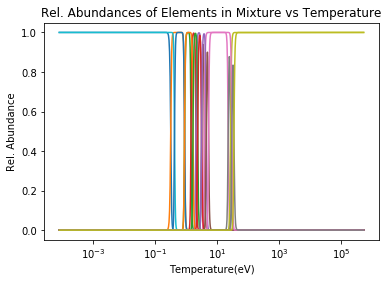

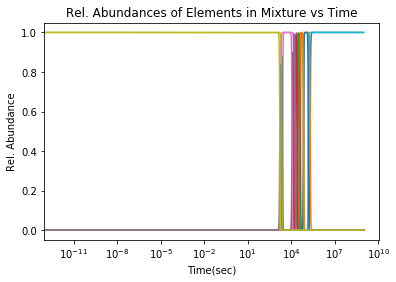

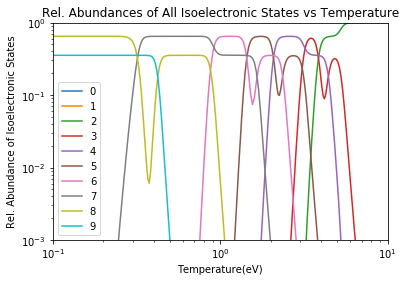

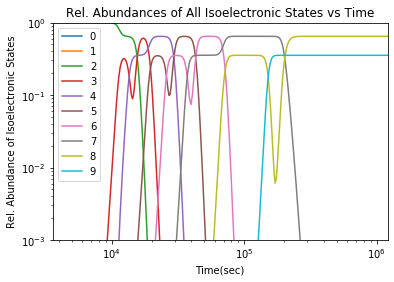

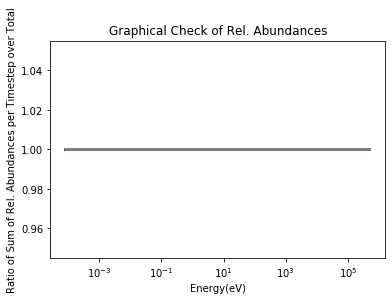

This calculation took 4.65625  sec to graph


In [9]:
#Call to function to generate data. Also, calculate time it takes.

time_start = process_time()
YI,bad,Ye_free = abundance_calculation([8,9])
time_elapsed = (process_time() - time_start)
print("This calculation took",time_elapsed,' sec')
plotter(YI)

In [10]:
#Saving Data as .txt files
'''time_start = process_time()
YI,bad,Ye_free = abundance_calculation(np.arange(1,104,1))
time_elapsed = (process_time() - time_start)
print("This calculation took",time_elapsed,' sec')

with open("bad_testing.txt", 'wb') as fp:
        pickle.dump(YI, fp)
        
with open("bad_array.txt", 'wb') as fp:
        pickle.dump(bad, fp)
        
with open("Ye_free.txt", 'wb') as fp:
        pickle.dump(Ye_free, fp)'''

'time_start = process_time()\nYI,bad,Ye_free = abundance_calculation(np.arange(1,104,1))\ntime_elapsed = (process_time() - time_start)\nprint("This calculation took",time_elapsed,\' sec\')\n\nwith open("bad_testing.txt", \'wb\') as fp:\n        pickle.dump(YI, fp)\n        \nwith open("bad_array.txt", \'wb\') as fp:\n        pickle.dump(bad, fp)\n        \nwith open("Ye_free.txt", \'wb\') as fp:\n        pickle.dump(Ye_free, fp)'

In [10]:
#Loading in the files
with open("bad_testing.txt", "rb") as fp:   # Unpickling
      YI = pickle.load(fp)
        
with open("bad_array.txt", "rb") as fp:   # Unpickling
      bad = pickle.load(fp)

with open("Ye_free.txt", "rb") as fp:   # Unpickling
      Ye_free = pickle.load(fp)

In [11]:
elemental,potentials = initialization(np.arange(1,104,1))

In [12]:
pd.DataFrame(YI[28])

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,5.457575e-14,1.133943e-13,2.355984e-13,4.894852e-13,1.016926e-12,2.112616e-12,4.388662e-12,9.116193e-12,1.893530e-11,3.932819e-11,...,1.210693e-07,2.506804e-07,5.189285e-07,0.000001,0.000002,0.000005,0.000010,0.000020,0.000040,0.000081
1,5.457575e-14,1.133943e-13,2.355984e-13,4.894852e-13,1.016926e-12,2.112616e-12,4.388662e-12,9.116193e-12,1.893530e-11,3.932819e-11,...,1.210693e-07,2.506804e-07,5.189285e-07,0.000001,0.000002,0.000005,0.000010,0.000020,0.000040,0.000081
2,5.457575e-14,1.133943e-13,2.355984e-13,4.894852e-13,1.016926e-12,2.112616e-12,4.388662e-12,9.116193e-12,1.893530e-11,3.932819e-11,...,1.210693e-07,2.506804e-07,5.189285e-07,0.000001,0.000002,0.000005,0.000010,0.000020,0.000040,0.000081
3,5.457575e-14,1.133943e-13,2.355984e-13,4.894852e-13,1.016926e-12,2.112616e-12,4.388662e-12,9.116193e-12,1.893530e-11,3.932819e-11,...,1.210693e-07,2.506804e-07,5.189285e-07,0.000001,0.000002,0.000005,0.000010,0.000020,0.000040,0.000081
4,5.457575e-14,1.133943e-13,2.355984e-13,4.894852e-13,1.016926e-12,2.112616e-12,4.388662e-12,9.116193e-12,1.893530e-11,3.932819e-11,...,1.210693e-07,2.506804e-07,5.189285e-07,0.000001,0.000002,0.000005,0.000010,0.000020,0.000040,0.000081
5,5.457575e-14,1.133943e-13,2.355984e-13,4.894852e-13,1.016926e-12,2.112616e-12,4.388662e-12,9.116193e-12,1.893530e-11,3.932819e-11,...,1.210693e-07,2.506804e-07,5.189285e-07,0.000001,0.000002,0.000005,0.000010,0.000020,0.000040,0.000081
6,5.457575e-14,1.133943e-13,2.355984e-13,4.894852e-13,1.016926e-12,2.112616e-12,4.388662e-12,9.116192e-12,1.893530e-11,3.932819e-11,...,1.210693e-07,2.506804e-07,5.189284e-07,0.000001,0.000002,0.000005,0.000010,0.000020,0.000040,0.000081
7,5.457574e-14,1.133943e-13,2.355984e-13,4.894851e-13,1.016926e-12,2.112616e-12,4.388662e-12,9.116192e-12,1.893530e-11,3.932819e-11,...,1.210693e-07,2.506804e-07,5.189284e-07,0.000001,0.000002,0.000005,0.000010,0.000020,0.000040,0.000081
8,5.457574e-14,1.133943e-13,2.355984e-13,4.894851e-13,1.016926e-12,2.112616e-12,4.388661e-12,9.116191e-12,1.893530e-11,3.932819e-11,...,1.210693e-07,2.506803e-07,5.189284e-07,0.000001,0.000002,0.000005,0.000010,0.000020,0.000040,0.000081
9,5.457572e-14,1.133943e-13,2.355983e-13,4.894850e-13,1.016926e-12,2.112615e-12,4.388661e-12,9.116190e-12,1.893529e-11,3.932818e-11,...,1.210693e-07,2.506803e-07,5.189284e-07,0.000001,0.000002,0.000005,0.000010,0.000020,0.000040,0.000081


C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


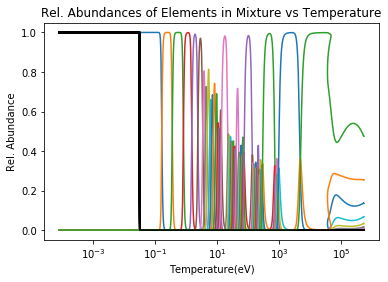

C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


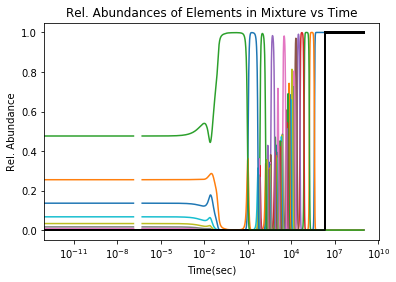

In [20]:
Y = YI[61]
#Temperature
Ytot = np.sum(Y,1)
#Ytot[18] = 1e-309
for i in range(len(Y[0])):
    plt.semilogx(kbEvpGK*np.array(full_temp),(Y[:,i])/Ytot)
    plt.semilogx(kbEvpGK*np.array(full_temp),bad,color = 'black')
    plt.xlabel("Temperature(eV)")
    plt.ylabel("Rel. Abundance")
    plt.title("Rel. Abundances of Elements in Mixture vs Temperature")
plt.show()

#Time
for i in range(len(Y[0])):
    plt.semilogx(np.array(time),(Y[:,i])/Ytot)
    plt.semilogx(np.array(time),bad,color = 'black')
    plt.xlabel("Time(sec)")
    plt.ylabel("Rel. Abundance")
    plt.title("Rel. Abundances of Elements in Mixture vs Time")
    #plt.xlim([3600,1.21e+6]) #1 hr to 2 weeks in sec
plt.show()


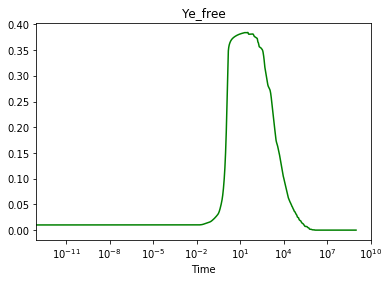

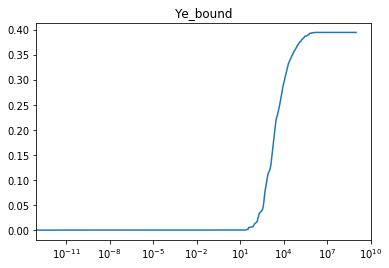

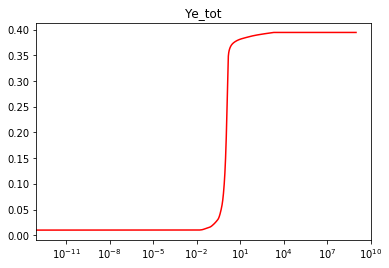

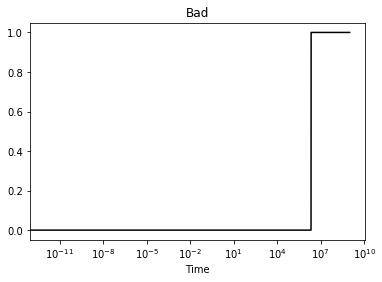

Text(0.5, 1.0, 'Fraction of Ye_free to Ye_total')

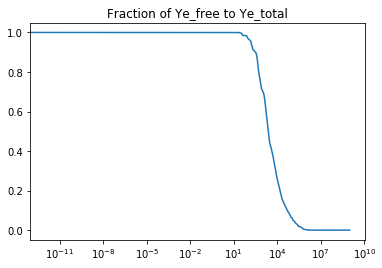

In [21]:
#plotting Ye_free, Ye_tot, and the bad array
plt.semilogx(time,Ye_free[0],color = 'green') #Ye_free[0] is only because the shape of Ye_free is (1,2198) for some reason
plt.title('Ye_free')
plt.xlabel('Time')
plt.show()

plt.semilogx(time,Ye_tot-Ye_free[0]) 
plt.title('Ye_bound')
plt.show()


plt.semilogx(time,Ye_tot,color = 'red')
plt.title('Ye_tot')
plt.show()

plt.title('Bad')
plt.semilogx(time,bad,color = 'black')
plt.xlabel('Time')
plt.show()

plt.semilogx(time,np.array(Ye_free[0])/np.array(Ye_tot))
plt.title('Fraction of Ye_free to Ye_total')

In [22]:
first_instance = 0
for i in range(len(bad)):
    if bad[i] == 1:
        first_instance = i
        break
first_instance

2041

In [23]:
print(Ytot[10])
print(np.max(YI[61][10]))
(YI[61][10][62])


4.627848343755342e-65
2.2033999751203625e-65


2.2033999751203625e-65

In [24]:
YI[61][10]

array([7.76396679e-85, 1.61315853e-84, 3.35170561e-84, 6.96376662e-84,
       1.44679619e-83, 3.00574972e-83, 6.24421523e-83, 1.29714784e-82,
       2.69456391e-82, 5.59716595e-82, 1.16260879e-81, 2.41480118e-81,
       5.01539105e-81, 1.04160694e-80, 2.16314749e-80, 4.49213129e-80,
       9.32809869e-80, 1.93639138e-79, 4.01944668e-79, 8.34273266e-79,
       1.73148393e-78, 3.59334047e-78, 7.45665131e-78, 1.54722098e-77,
       3.21016430e-77, 6.65991337e-77, 1.38158084e-76, 2.86519828e-76,
       5.94154600e-76, 1.23199031e-75, 2.55434175e-75, 5.29524477e-75,
       1.09762615e-74, 2.27475075e-74, 4.71380449e-74, 9.74940884e-74,
       2.01606816e-73, 4.16817195e-73, 8.61581122e-73, 1.78056443e-72,
       3.67901045e-72, 7.59951584e-72, 1.56945648e-71, 3.24052371e-71,
       6.68942425e-71, 1.38008319e-70, 2.84669097e-70, 5.87064083e-70,
       1.21045427e-69, 2.49457319e-69, 5.13986513e-69, 1.05859534e-68,
       2.17980861e-68, 4.43815607e-68, 9.03153739e-68, 1.83683653e-67,
      

Text(0.5, 1.0, 'Total Abundance of Samarium vs Time')

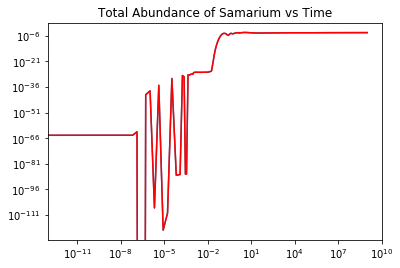

In [25]:
#Graphing The Sm abundance vs time. Remove the comment below to show graphical overlap
plt.loglog(time,elemental[61])
plt.loglog(time,Ytot,color = 'red')
plt.title('Total Abundance of Samarium vs Time')

C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


There are these many values that differ:  806


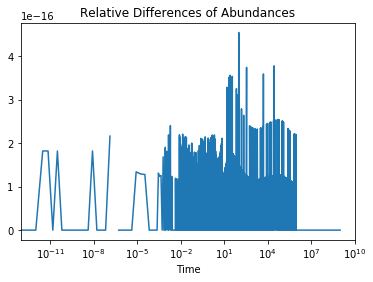

In [26]:
#Understanding the difference between Ytot and the elemental abundances from skynet
diff = (np.array(elemental[61]) - np.array(Ytot))/elemental[61]
indices = []
values = []
for i in range(len(diff)):
    if diff[i] != 0:
        indices.append(i)
        values.append(diff[i])

print('There are these many values that differ: ',len(values))
plt.semilogx(time,np.abs(diff))
plt.xlabel('Time')
plt.title('Relative Differences of Abundances')
plt.show()

In [ ]:
for i in range(104):
    time_start = process_time()
    YI = abundance_calculation(np.arange(1,1+i,1))
    time_elapsed = process_time() - time_start
    file = 'calculation' + str((1+i)) + '.txt'
    with open(file, 'wb') as fp:
        pickle.dump(YI, fp)
    print(time_elapsed,' sec for this calculation')

In [ ]:
#Call to function to generate data. Also, calculate time it takes.

'''time_start = process_time()
YI = abundance_calculation(np.arange(1,104,1))
time_elapsed = (process_time() - time_start)
print("This calculation took",time_elapsed,' sec')

#with open('All_class_adjusted.txt', 'wb') as fp:
    #pickle.dump(YI, fp)'''

In [ ]:
#This is the calculation to make the time plot. Currently, it is commented out for convenience
'''times = []
elements = np.arange(1,104,1)

for i in elements:
    time_start = process_time()
    YI = abundance_calculation([i])
    times.append(process_time() - time_start)
    
plt.plot(elements,times)
plt.xlabel('Element Number')
plt.ylabel('Times(sec)')
plt.title('Calculation Times for Abundances')
plt.grid()
plt.savefig('times.png')'''

In [ ]:
#This cell exists to make the entire lanthanide calculation. 
time_start = process_time()
YI = abundance_calculation(np.arange(58,72,1))
time_elapsed = process_time() - time_start
time_elapsed

In [ ]:
with open("Lanthanides.txt", "rb") as fp:   # Unpickling
      YI = pickle.load(fp)

In [ ]:
plotter(YI)

In [ ]:
#Just plotting all the lanthanide abundances seperately
element_num = 58 #Z of first lanthanide
for Y in YI:
    #Temperature
    Ytot = np.sum(Y,1)
    print('This is the graph for element ',element_num,'so there are ',element_num+1,' ionization states graphed')
    for i in range(len(Y[0])):
        plt.semilogx(kbEvpGK*np.array(full_temp),(Y[:,i])/Ytot)
        plt.xlabel("Temperature(eV)")
        plt.ylabel("Rel. Abundance")
        plt.title("Rel. Abundances of Elements in Mixture vs Temperature")
    plt.show()
    
    #Time
    for i in range(len(Y[0])):
        plt.semilogx(np.array(time),(Y[:,i])/Ytot)
        plt.xlabel("Time(sec)")
        plt.ylabel("Rel. Abundance")
        plt.title("Rel. Abundances of Elements in Mixture vs Time")
        plt.xlim([3600,1.21e+6])
    element_num+=1
    plt.show()
        

In [ ]:
isotopic_abundances,potentials = initialization(np.arange(58,72,1))

In [ ]:
for i in range(len(isotopic_abundances)):
    print('This is the abundance graph of element: ',(i+58))
    Ytot_isotopic = np.sum(isotopic_abundances[i])
    plt.semilogx(kbEvpGK*np.array(full_temp),isotopic_abundances[i]/Ytot_isotopic,label = (i+58))
    plt.legend()
    plt.xlabel("Temperature(eV)")
    plt.ylabel("Total Abundance of Each Lanthanide")
    plt.title("Abundances of All Elemental Abundances vs Temperature")
    plt.show()

In [ ]:
#This cell exists to make the entire lanthanide+actinide calculation. 
time_start = process_time()
YI = abundance_calculation(np.arange(58,103,1))
time_elapsed = process_time() - time_start
time_elapsed

In [ ]:
with open("Lanthanides_Actinides.txt", "rb") as fp:   # Unpickling
      YI = pickle.load(fp)

In [ ]:
plotter(YI)

In [ ]:
#Just plotting all the lanthanide and actinide abundances seperately
element_num = 58 #Z of first lanthanide
for Y in YI:
    Ytot = np.sum(Y,1)
    print('This is the graph for element ',element_num,'so there are ',element_num+1,' ionization states graphed')
    for i in range(len(Y[0])):
        plt.semilogx(kbEvpGK*np.array(full_temp),(Y[:,i])/Ytot)
        plt.xlabel("Temperature(eV)")
        plt.ylabel("Rel. Abundance")
        plt.title("Rel. Abundances of Elements in Mixture vs Temperature")
    plt.show()
    for i in range(len(Y[0])):
        plt.semilogx(np.array(time),(Y[:,i])/Ytot)
        plt.xlabel("Time(sec)")
        plt.ylabel("Rel. Abundance")
        plt.title("Rel. Abundances of Elements in Mixture vs Time")
        plt.xlim([3600,1.21e+6])
    element_num+=1
    plt.show()
        